# Fund performance against index
> Reading Warren Buffet I wanted to test if polish equity funds are performing as bad as those in 60's and 70's, when he was complaining about them.

- toc: false 
- hide: false
- badges: true
- comments: true
- categories: [ML, investing]

Fund pricing data I got from [inwestinfo.pl](https://www.inwestinfo.pl/fundusze/fundusze-inwestycyjne/wszystkie/?funduszeKategorie%5B%5D=10&archiwum=1) website and indicies prices from [stooq.pl](https://stooq.pl/).

## Getting the data

In [1]:
#collapse
#collapse-output

!pip install bs4 pandas fastcore seaborn

In [2]:
#collapse

import datetime
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib3
urllib3.disable_warnings() # disable ssl verification warnings
from fastcore.parallel import parallel
from functools import reduce
import seaborn as sns

In [3]:
#collapse

start_date = datetime.datetime.strptime('1995-09-01', '%Y-%m-%d').date()

def dates_since(start_date):
    d = start_date
    while d < datetime.date.today():
        yield d
        d += datetime.timedelta(days=1)

def get_fund_prices_for_day(day):
    print(".", end="")
    # stock funds from date d
    url = f'https://www.inwestinfo.pl/fundusze/fundusze-inwestycyjne/wszystkie/?funduszeKategorie%5B%5D=10&archiwum=1&dataArchiwum={day}'
    res = requests.get(url, verify=False) # do not verify the certificate
    
    quotes = []
    
    soup = BeautifulSoup(res.content, 'html.parser')
    
    try:
        table = soup.find(class_='table-data')
        table = table.find('tbody')
        for row in table.find_all('tr'):
            cells = row.find_all('td')
            name = cells[2].get_text()
            date = cells[3].get_text()
            price = cells[4].get_text()

            quotes += [(name, date, price)]
    except: # if parsing doesn't go as planned (for example no quotes for that day)
        pass

    return quotes

In [4]:
print("Getting fund pricing data ...", end="")

quotes = parallel( # run in parallel to speed it up
                get_fund_prices_for_day, 
                dates_since(start_date), 
                n_workers=16, 
                progress=False
)
quotes = reduce(lambda q1, q2: q1 + q2, quotes) # drop unnecessary dimension

df = pd.DataFrame.from_records(quotes, columns=['name', 'date', 'price'])
df['date'] = pd.to_datetime(df['date'])
df['price'] = df.price.astype(np.double)

print("Done")

Getting fund pricing data ..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
indexes = ['wig', 'wig20']

print(f"Getting pricing data for {', '.join(indexes)} ... ", end="")
for index in indexes:
    df_index = pd.read_csv(f'https://stooq.pl/q/d/l/?s={index}&i=y', parse_dates=['Data']) # get raw data as csv
    df_index['name'] = index.upper()
    df_index = df_index.rename(columns={'Data':'date', 'Zamkniecie': 'price'})[['name', 'date', 'price']]
    df = df.append(df_index) # append index data to fund pricing data
print('Done')

Getting pricing data for wig, wig20 ... Done


In [12]:
# get years' last price and difference for each fund
df['year'] = df.date.apply(lambda d: d.year)

df_fund_year_prices = df.groupby(['name', 'year'])\
   .apply(lambda gr: gr[gr['date'] == gr['date'].max()]['price'])\
   .reset_index()[['name', 'year', 'price']]\
   .drop_duplicates()

# get previous price
df_fund_year_prices['price_prev'] = df_fund_year_prices.price.shift(1)

df_fund_year_prices['price_change_pct'] = (df_fund_year_prices['price'] - df_fund_year_prices['price_prev']) / df_fund_year_prices['price_prev'] * 100

In [13]:
years_on_market_threshold = 20 # limit to funds that are around long enough

df_long_time_on_market = df_fund_year_prices.groupby('name').aggregate({'year':'count'}).rename(columns={'year':'years_on_market'})
df_long_time_on_market = df_long_time_on_market[df_long_time_on_market.years_on_market > years_on_market_threshold]

long_time_on_market_names = df_long_time_on_market.reset_index().name.values

## Results

The results look not so bad, but take a look and judge for yourself. The important thing is to takie into consideration compounding and that even small differences in returns early during the investing period produce huge differences for final value of the holdings.

In [14]:
# hide
# sns.choose_diverging_palette()

In [17]:
cmap = sns.diverging_palette(h_neg=134, h_pos=10, n=5, center='light', as_cmap=True)

df_fund_year_prices_old = df_fund_year_prices[
    df_fund_year_prices.name.isin(long_time_on_market_names) & 
    (df_fund_year_prices.price_change_pct < 100) & # remove some outliers - fund conversions
    (df_fund_year_prices.price_change_pct > -70) & # remove some outliers
    (df_fund_year_prices.year < datetime.date.today().year) # consider only full years
]

df_fund_year_prices_old.pivot(index='year', columns='name', values='price_change_pct')\
 .style.background_gradient(cmap=cmap, axis=1)\
 .highlight_null('white')

name,Esaliens Akcji (d.Legg Mason Akcji),Novo Akcji,Pekao Akcji Polskich,Santander Akcji Polskich,Skarbiec Akcja,WIG,WIG20
year,,,,,,,
1992,nan,nan,nan,nan,nan,13.219454,13.201320
1994,nan,nan,nan,nan,nan,-39.922019,-40.478127
1995,nan,nan,2.337398,nan,nan,1.509414,8.183060
1996,nan,nan,80.834161,nan,nan,89.071831,82.068443
1997,nan,nan,4.887424,nan,nan,2.267340,3.148842
1998,nan,nan,-14.712042,9.256845,nan,-12.765203,-16.541151
1999,nan,29.195117,34.868017,34.486874,36.931818,41.326706,44.102481
2000,-0.547880,-0.192184,0.045517,20.674357,18.153527,-1.305050,1.542547
2001,-16.295409,-18.485237,-16.424022,-11.323529,-20.913082,-21.993994,-33.468415


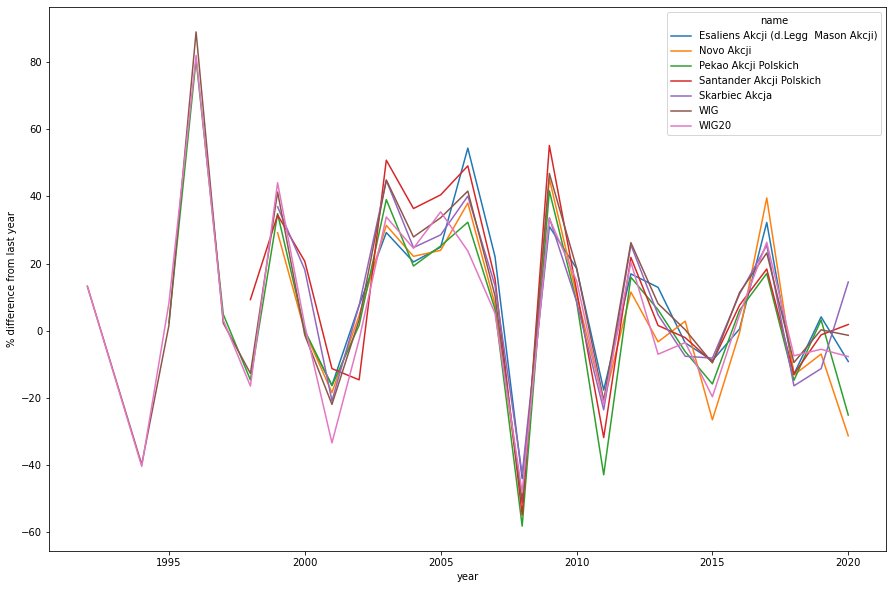

In [20]:
plt = df_fund_year_prices_old.pivot(index='year', columns='name', values='price_change_pct')\
                       .plot(figsize=(15,10), ylabel="% difference from last year")

TODO:
 - compounded results and comparison with indexes
 - test if compounded results are simillar with real fund price at the end